# **Generating Bianconi–Barabási Networks**

## **Initializing the algorithm**

In [1]:
using Statistics, Distributions, Plots, StatsBase, StatsPlots, ProgressMeter, LsqFit, LaTeXStrings, Plots.PlotMeasures

println("Packages loaded.\n")

mutable struct Network
    Nodes::Vector{Int} # List of nodes
    Neighbors::Vector{Vector{Int}} # List of edges
    Fitnesses::Vector{Float64} # List of fitnesses
    m::Int
    t::Int
end

# function GetNeighbors(network::Network, n::Int)
#     return [first.(network.Eadges[findall(x -> x[2] == n, network.Eadges)])...,
#         last.(network.Eadges[findall(x -> x[1] == n, network.Eadges)])...]
# end

function GetInitNetwork(m::Int)
    # Udirected complete graph with m nodes
    nodes = collect(1:m)
    neighbors = [[j for j ∈ nodes if j != i] for i ∈ nodes]
    return Network(nodes, neighbors, rand(m), m, 0)
end

function BANextStep!(TheNetwork::Network) # Barabasi-Albert Model step
    Samples = sample(TheNetwork.Nodes, Weights((length.(TheNetwork.Neighbors) .* TheNetwork.Fitnesses) ./ sum(length.(TheNetwork.Neighbors) .* TheNetwork.Fitnesses)), TheNetwork.m, replace=true)
    push!(TheNetwork.Nodes, TheNetwork.Nodes[end] + 1)
    push!(TheNetwork.Fitnesses, rand())
    push!(TheNetwork.Neighbors, Samples)
    push!.(TheNetwork.Neighbors[Samples], TheNetwork.Nodes[end])
    TheNetwork.t += 1
    return TheNetwork
end

function GetClusteringCoefficient(TheNetwork::Network, n::Int)
    Neighbors = TheNetwork.Neighbors[n]
    if length(Neighbors) < 2
        return 0
    end
    Triangles = 0
    for i ∈ 1:length(Neighbors)
        for j ∈ (i+1):length(Neighbors)
            if Neighbors[j] ∈ TheNetwork.Neighbors[Neighbors[i]]
                Triangles += 1
            end
        end
    end
    return Triangles / (length(Neighbors) * (length(Neighbors) - 1) / 2)
end

println("Functions defined.")

Packages loaded.

Functions defined.


## **Exporting the required data**

In [37]:
TheNetwork = GetInitNetwork(10)
DegreeVault = Vector[]
AvgClusterCoeffs = Float64[]
@showprogress for i ∈ 1:10000
    TheNetwork = BANextStep!(TheNetwork)
    if i % 100 == 0
        push!(DegreeVault, length.(TheNetwork.Neighbors))
        push!(AvgClusterCoeffs, mean([GetClusteringCoefficient(TheNetwork, i) for i ∈ TheNetwork.Nodes]))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


## **Fitting the power law**

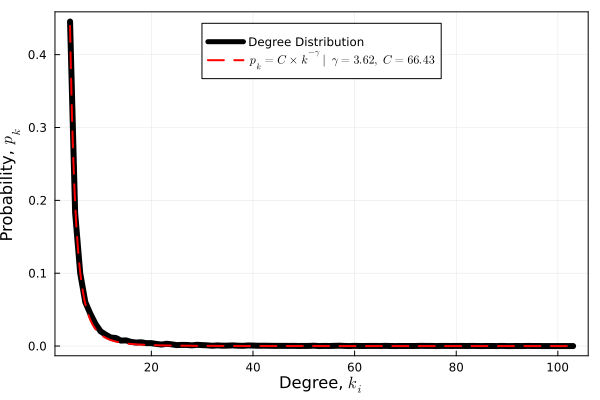

In [13]:
xdata = collect(4.0:maximum(DegreeVault[end]))
Degree_Dist = [count(isequal(k), DegreeVault[end]) for k ∈ xdata]
ydata = Degree_Dist / sum(Degree_Dist)
p0 = [10.0, 3.0]
@. pₖ(k, p) = p[1] * (k^(-p[2]))
DistFit = LsqFit.curve_fit(pₖ, xdata, ydata, p0)
PDF_Coefs = round.(coef(DistFit), digits=2)

plot(xdata[1:100], ydata[1:100], label="Degree Distribution", c=:black, lw=6, legend=:top,
    xlabel="Degree, " * L"k_i", ylabel="Probability, " * L"p_k", frame=:box)
plot!(k -> pₖ(k, PDF_Coefs), xdata[1], xdata[100],
    label=L"p_k = C\times k^{-\gamma}\ |\ \gamma = %$(PDF_Coefs[2]),\ C = %$(PDF_Coefs[1])",
    c=:red, ls=:dash, lw=2)

## **PDF and CDF of degrees over time**

[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Desktop\Code\Network-Science\ProbSet7\tmp.gif


Plots.AnimatedGif("c:\\Users\\shahm\\OneDrive\\Desktop\\Desktop\\Code\\Network-Science\\ProbSet7\\tmp.gif")
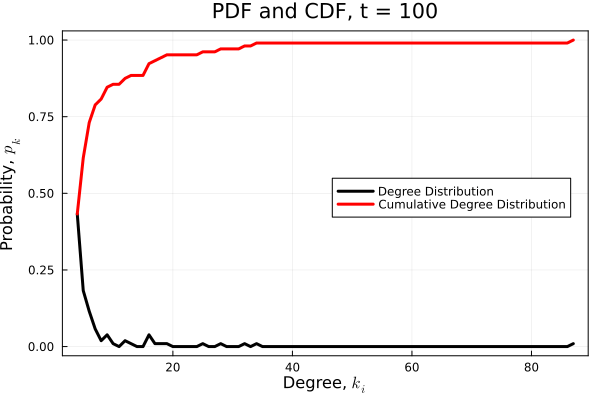

In [14]:
@gif for (i, Degree) ∈ enumerate(DegreeVault)
    kᵢs = collect(4.0:maximum(Degree))
    Degree_Dist = [count(isequal(k), Degree) for k ∈ kᵢs]
    Degree_Density_Dist = Degree_Dist / sum(Degree_Dist)
    Cum_Degree_Dist = [count(x -> x <= k, Degree) for k ∈ kᵢs]
    Cum_Density_Dist = Cum_Degree_Dist / maximum(Cum_Degree_Dist)
    plot(kᵢs, Degree_Density_Dist, label="Degree Distribution", c=:black, lw=3, legend=:right,
        xlabel="Degree, " * L"k_i", ylabel="Probability, " * L"p_k", frame=:box)
    plot!(kᵢs, Cum_Density_Dist, label="Cumulative Degree Distribution", c=:red, lw=3, title="PDF and CDF, t = $(i * 100)")
end

## **Degree distribution over time (Histogram)**

[ Info: Saved animation to c:\Users\shahm\OneDrive\Desktop\Desktop\Code\Network-Science\ProbSet7\tmp.gif


Plots.AnimatedGif("c:\\Users\\shahm\\OneDrive\\Desktop\\Desktop\\Code\\Network-Science\\ProbSet7\\tmp.gif")
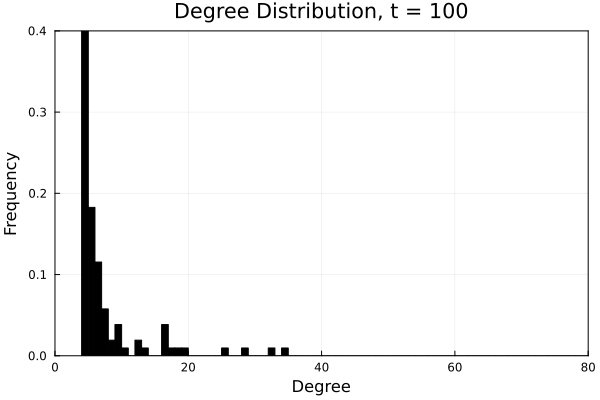

In [15]:
@gif for (i, Degrees) ∈ enumerate(DegreeVault)
    histogram(Degrees, bins=maximum(Degrees), ylim=(0, 0.4), xlim=(0, 80),
        normalize=:probability, label=nothing, xlabel="Degree", ylabel="Frequency",
        title="Degree Distribution, t = $(i * 100)", c = :black, frame=:box)
end

## **Average cluster coefficient over time, ($\langle C \rangle$ function of N)**

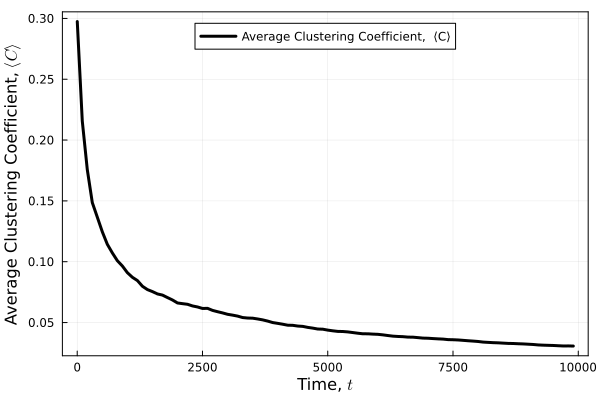

In [16]:
plot(1:100:10000, AvgClusterCoeffs, label="Average Clustering Coefficient,  ⟨C⟩", c=:black, lw=3, legend=:top,
    xlabel="Time, " * L"t", ylabel="Average Clustering Coefficient, " * L"\langle C \rangle", frame=:box)

## **Degree Dynamics**

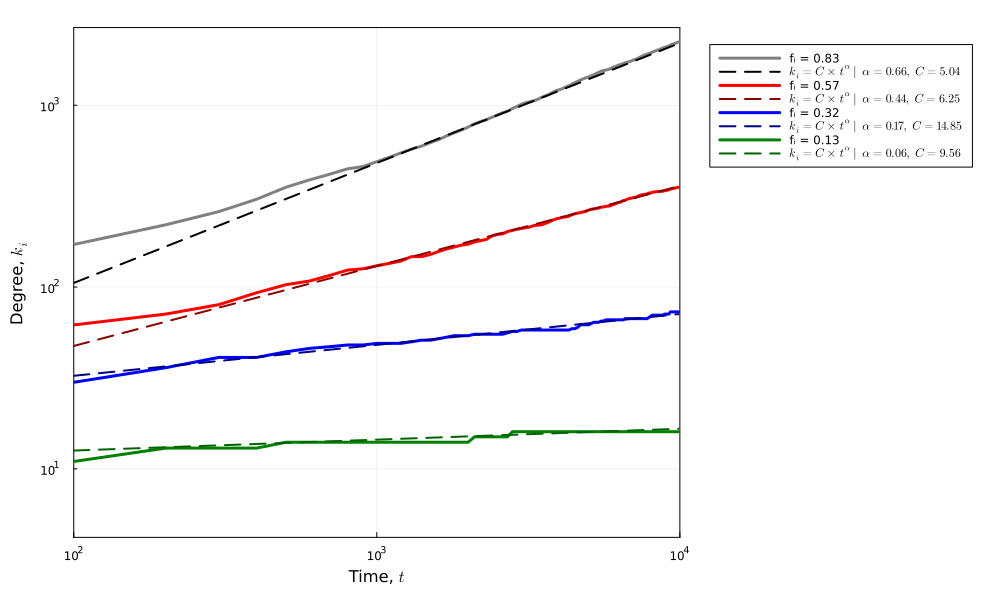

In [128]:
t_steps = collect(1:100:10000)
Ks_1 = getindex.(DegreeVault, 2)
Ks_2 = getindex.(DegreeVault, 1)
Ks_3 = getindex.(DegreeVault, 3)
Ks_4 = getindex.(DegreeVault, 4)

@. pₖ(t, p) = p[1] * (t^(p[2]))
DistFit = LsqFit.curve_fit(pₖ, t_steps, Ks_1, [1.0, 0.1])
Ks_1_fit = round.(coef(DistFit), digits=2)
DistFit = LsqFit.curve_fit(pₖ, t_steps, Ks_2, [1.0, 0.1])
Ks_2_fit = round.(coef(DistFit), digits=2)
DistFit = LsqFit.curve_fit(pₖ, t_steps, Ks_3, [1.0, 0.1])
Ks_3_fit = round.(coef(DistFit), digits=2)
DistFit = LsqFit.curve_fit(pₖ, t_steps, Ks_4, [1.0, 0.1])
Ks_4_fit = round.(coef(DistFit), digits=2)

plot(t_steps, Ks_1, label="fᵢ = $(round(TheNetwork.Fitnesses[2], digits=2))", c=:grey, lw=3)
plot!(t->pₖ(t, Ks_1_fit), t_steps[1], t_steps[end], label=L"k_i = C\times t^{\alpha}\ |\ \alpha = %$(Ks_1_fit[2]),\ C = %$(Ks_1_fit[1])", c=:black, ls=:dash, lw=2)
plot!(t_steps, Ks_2, label="fᵢ = $(round(TheNetwork.Fitnesses[1], digits=2))", c=:red, lw=3)
plot!(t->pₖ(t, Ks_2_fit), t_steps[1], t_steps[end], label=L"k_i = C\times t^{\alpha}\ |\ \alpha = %$(Ks_2_fit[2]),\ C = %$(Ks_2_fit[1])", c=:darkred, ls=:dash, lw=2)
plot!(t_steps, Ks_3, label="fᵢ = $(round(TheNetwork.Fitnesses[3], digits=2))", c=:blue, lw=3)
plot!(t->pₖ(t, Ks_3_fit), t_steps[1], t_steps[end], label=L"k_i = C\times t^{\alpha}\ |\ \alpha = %$(Ks_3_fit[2]),\ C = %$(Ks_3_fit[1])", c=:darkblue, ls=:dash, lw=2)
plot!(t_steps, Ks_4, label="fᵢ = $(round(TheNetwork.Fitnesses[4], digits=2))", c=:green, lw=3)
plot!(t->pₖ(t, Ks_4_fit), t_steps[1], t_steps[end], label=L"k_i = C\times t^{\alpha}\ |\ \alpha = %$(Ks_4_fit[2]),\ C = %$(Ks_4_fit[1])", c=:darkgreen, ls=:dash, lw=2)
plot!(xscale=:log10, yscale=:log10, xlabel="Time, " * L"t", ylabel="Degree, " * L"k_i", frame=:box, xlim=(100, 10000), legend=:outertopright, size = (1000, 600), margin = 5mm)

# **Solution to Evolving Network Model Question**

## (a) Time evolution of node degrees

The rate at which node $i$ receives new links is:  

$\dfrac{dk_i}{dt} = \Pi_i = \dfrac{\eta_i}{t\langle\eta\rangle}$

Integrating this over time $t$, using the initial condition $k_i(t_i) = 1$, gives:

$k_i(t) = 1 + \dfrac{\eta_i}{\langle\eta\rangle}\ln(\dfrac{t}{t_i})$

## (b) Degree distribution for nodes with attractiveness $\eta$ 

Let $P_\eta(k_i \leq k)$ be the cumulative distribution that node $i$ with attractiveness $\eta$ has degree less than or equal to $k$.  

Then,

$\dfrac{\partial P_\eta(k_i \leq k)}{\partial k_i} = p_\eta(k)$

Using the solution for $k_i(t)$ from part (a), we have:

$k_i(t) \approx \dfrac{\eta}{\langle\eta\rangle} \ln(\dfrac{t}{t_i}) \leq k$

Which gives:  

$P_\eta(k_i \leq k) \approx e^{-\langle\eta\rangle k/\eta}$  

Taking the derivative with respect to $k$ gives:

$\dfrac{\partial P_\eta(k_i \leq k)}{\partial k} = p_\eta(k) = \dfrac{\langle\eta\rangle}{\eta} e^{-\langle\eta\rangle k/\eta}$

## (c) Degree distribution for equal fractions of $\eta=1$ and $\eta=2$

With equal fractions of nodes having $\eta=1$ and $\eta=2$,  

$\langle \eta \rangle = \dfrac{1}{2} \times 1 + \dfrac{1}{2} \times 2 = 1.5$

The overall degree distribution is:  

$p(k) = 1.5e^{-1.5k} + 0.75e^{-0.75k}$